Column names after setting: Index(['time', 'energy', 'Re_lambda'], dtype='object')
Checking for NaN values in energy data:
time         1
energy       1
Re_lambda    1
dtype: int64
Checking for infinite values in energy data:
[0 0 0]
   time    energy  Re_lambda
1  0.00  0.682040   426.8378
2  0.02  0.681970   426.9046
3  0.04  0.681909   426.9681
4  0.06  0.681860   427.0309
5  0.08  0.681831   427.0796


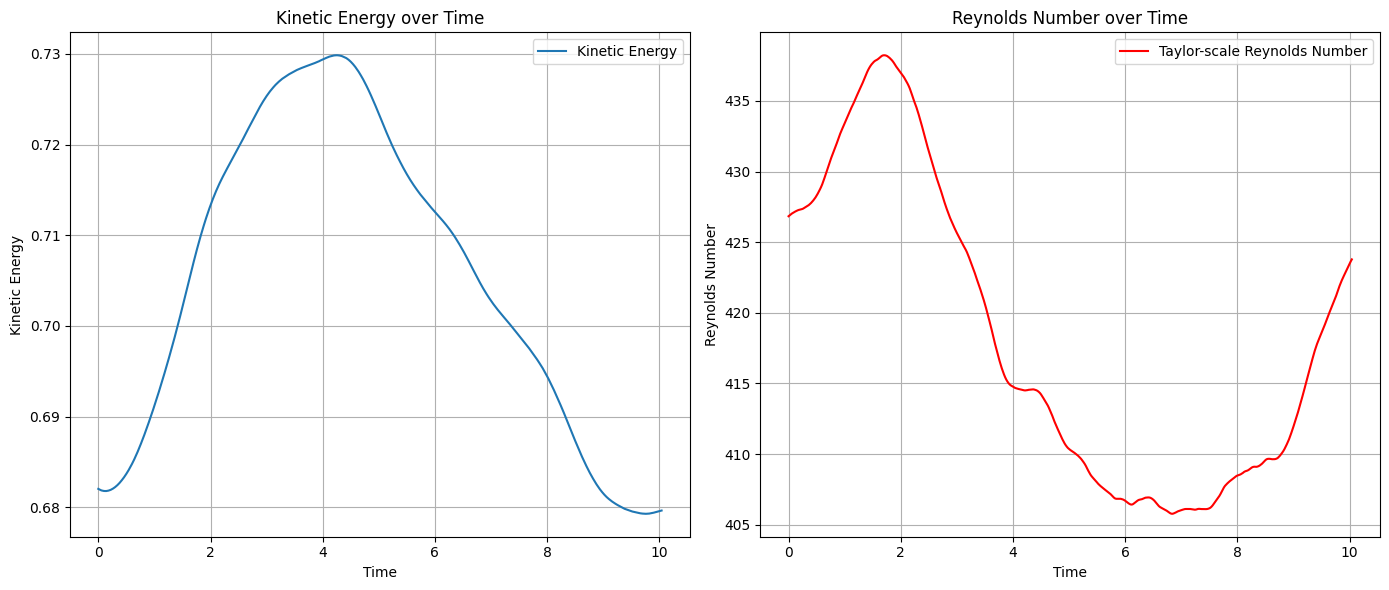

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Define column names based on the structure of the file
column_names = ['time', 'energy', 'Re_lambda']

# Load the kinetic energy and Reynolds number data with the correct column names and delimiter
file_path = 'ener_Re_time.txt'  # Replace with the correct path
ener_re_data = pd.read_csv(file_path, delim_whitespace=True, names=column_names, skiprows=1)

# Display the column names to check for any issues
print("Column names after setting:", ener_re_data.columns)

# Convert columns to numeric, forcing errors to NaN
ener_re_data['time'] = pd.to_numeric(ener_re_data['time'], errors='coerce')
ener_re_data['energy'] = pd.to_numeric(ener_re_data['energy'], errors='coerce')
ener_re_data['Re_lambda'] = pd.to_numeric(ener_re_data['Re_lambda'], errors='coerce')

# Check for NaN or infinite values
print("Checking for NaN values in energy data:")
print(ener_re_data.isna().sum())

print("Checking for infinite values in energy data:")
print(np.isinf(ener_re_data.to_numpy()).sum(axis=0))

# Handle NaN or infinite values (e.g., by filling with mean or median)
ener_re_data = ener_re_data.replace([np.inf, -np.inf], np.nan).dropna()

# Display the first few rows to ensure data is loaded correctly
print(ener_re_data.head())

time = ener_re_data['time']
energy = ener_re_data['energy']
re_lambda = ener_re_data['Re_lambda']

# Plot kinetic energy and Reynolds number over time
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(time, energy, label='Kinetic Energy')
plt.xlabel('Time')
plt.ylabel('Kinetic Energy')
plt.title('Kinetic Energy over Time')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time, re_lambda, color='red', label='Taylor-scale Reynolds Number')
plt.xlabel('Time')
plt.ylabel('Reynolds Number')
plt.title('Reynolds Number over Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

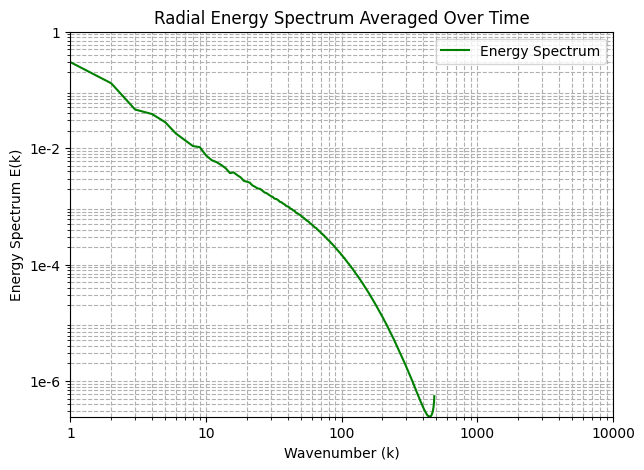

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the energy spectrum data
spectrum_data = pd.read_csv('spectrum.txt', delim_whitespace=True)

# Convert k and E(k) to numeric, forcing errors to NaN
spectrum_data['k'] = pd.to_numeric(spectrum_data['k'], errors='coerce')
spectrum_data['E(k)'] = pd.to_numeric(spectrum_data['E(k)'], errors='coerce')

# Clean the data to ensure no NaNs or Infs
spectrum_data = spectrum_data.replace([np.inf, -np.inf], np.nan).dropna()

# Extract the cleaned k and E(k)
k = spectrum_data['k']
E_k = spectrum_data['E(k)']

# Plot the radial energy spectrum with improved visualization
plt.figure(figsize=(7, 5))
plt.loglog(k, E_k, label='Energy Spectrum', color='green')
plt.xlabel('Wavenumber (k)')
plt.ylabel('Energy Spectrum E(k)')
plt.title('Radial Energy Spectrum Averaged Over Time')
plt.grid(True, which="both", ls="--")
plt.legend()

# Set limits for better visualization
plt.xlim(1, max(k))
plt.ylim(min(E_k), max(E_k))

# Adjust tick positions and labels
plt.xticks([1, 10, 100, 1000, 10000], ['1', '10', '100', '1000', '10000'])
plt.yticks([1e-6, 1e-4, 1e-2, 1], ['1e-6', '1e-4', '1e-2', '1'])

plt.show()

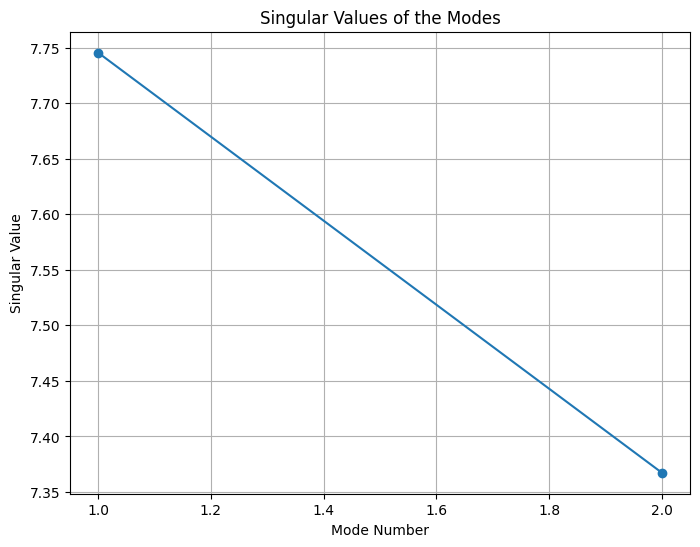

In [62]:
# Function to perform POD on the data
def perform_pod(data, num_modes):
    # Subtract mean
    mean_data = np.mean(data, axis=0)
    data_centered = data - mean_data

    # Check for NaN or infinite values in the centered data
    if np.any(np.isnan(data_centered)) or np.any(np.isinf(data_centered)):
        raise ValueError("Data contains NaNs or Infs after centering")

    # SVD decomposition
    U, S, Vt = svd(data_centered, full_matrices=False)
    modes = U[:, :num_modes]
    singular_values = S[:num_modes]
    temporal_coefficients = np.dot(data_centered, Vt.T[:, :num_modes])

    return modes, singular_values, temporal_coefficients, mean_data

# Perform POD
num_modes = 10
modes, singular_values, temporal_coefficients, mean_data = perform_pod(normalized_data, num_modes)

# Adjust num_modes if necessary
num_modes = min(num_modes, temporal_coefficients.shape[1])

# Plot the singular values to determine the number of significant modes
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(singular_values) + 1), singular_values, 'o-')
plt.xlabel('Mode Number')
plt.ylabel('Singular Value')
plt.title('Singular Values of the Modes')
plt.grid(True)
plt.show()

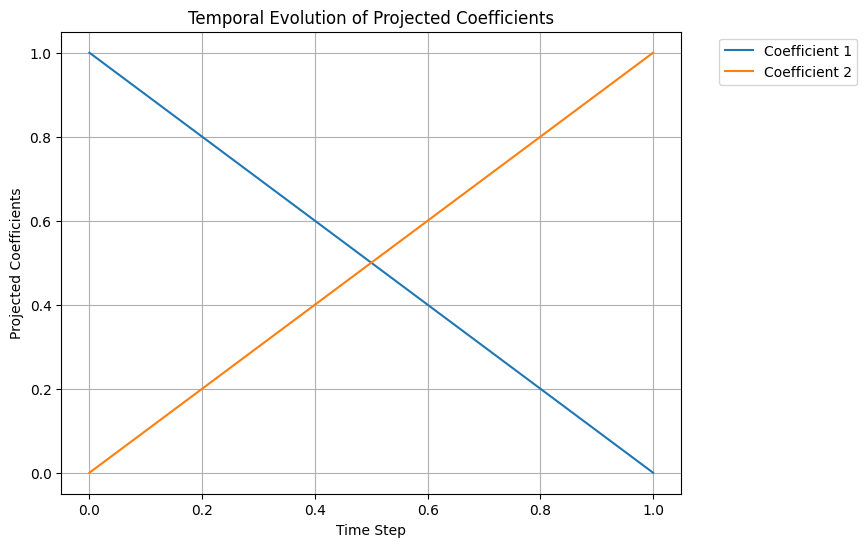

In [64]:
# Function to perform Galerkin projection
def galerkin_projection(modes, temporal_coefficients, num_modes):
    # Truncate the modes and coefficients
    truncated_modes = modes[:, :num_modes]
    truncated_coefficients = temporal_coefficients[:, :num_modes]

    # Calculate the projected coefficients
    projected_coefficients = np.dot(truncated_modes.T, truncated_modes)

    return projected_coefficients

# Perform Galerkin projection
projected_coefficients = galerkin_projection(modes, temporal_coefficients, num_modes)

# Example visualization of the projected coefficients
plt.figure(figsize=(8, 6))
for i in range(projected_coefficients.shape[1]):
    plt.plot(projected_coefficients[:, i], label=f'Coefficient {i+1}')
plt.xlabel('Time Step')
plt.ylabel('Projected Coefficients')
plt.title('Temporal Evolution of Projected Coefficients')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Shape of X_train: (402, 3, 2)
Shape of X_val: (101, 3, 2)
Shape of y_train: (402, 2)
Shape of y_val: (101, 2)
First few examples of X_train: [[[0.01030585 0.58078458]
  [0.00808701 0.57976926]
  [0.00607002 0.57874774]]

 [[0.00808701 0.57976926]
  [0.00607002 0.57874774]
  [0.00425518 0.57762755]]]
First few examples of y_train: [[0.00425518 0.57762755]
 [0.00299785 0.57666719]]
Epoch 1/50
41/41 [==============================] - 2s 11ms/step - loss: 0.1452 - val_loss: 0.1363
Epoch 2/50
41/41 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0431
Epoch 3/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0050
Epoch 4/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 5.6241e-04
Epoch 5/50
41/41 [==============================] - 0s 3ms/step - loss: 9.6532e-04 - val_loss: 5.1872e-04
Epoch 6/50
41/41 [==============================] - 0s 3ms/step - loss: 6.6288e-04 - val_loss: 4.5965e-04
Epoch 7/

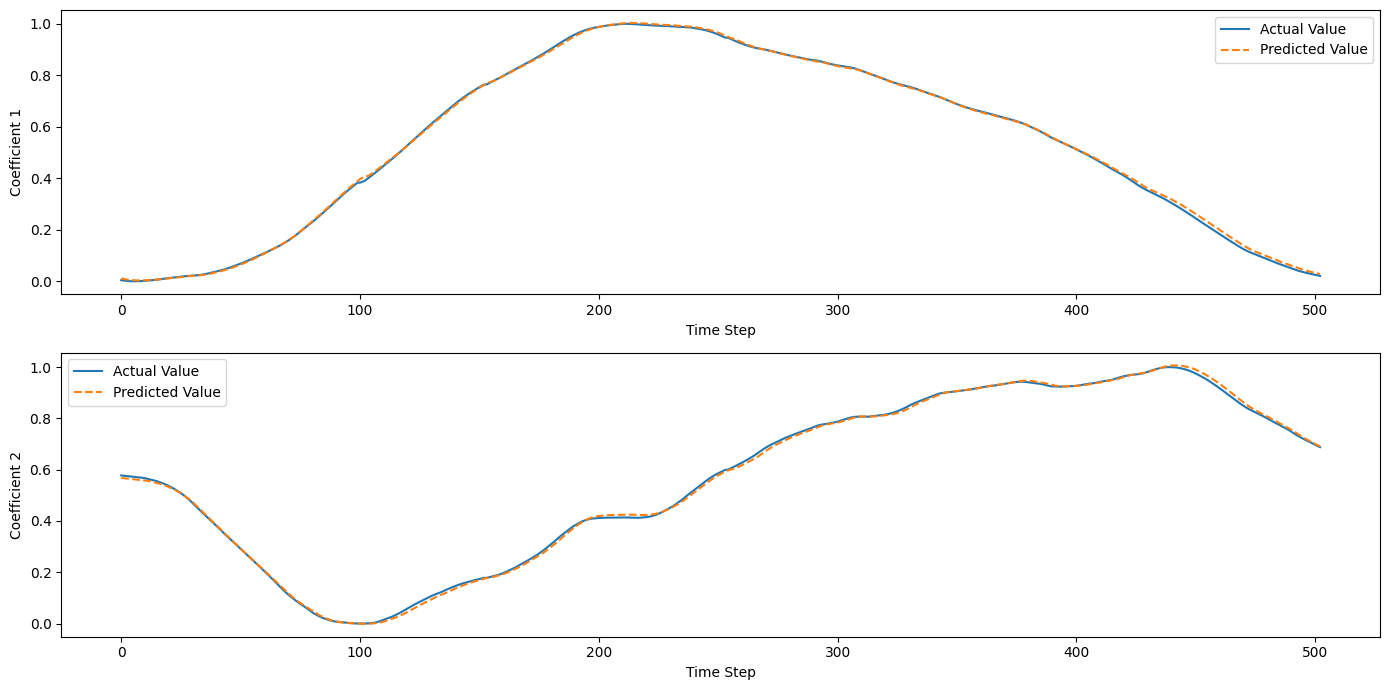

In [66]:
# Prepare the data for LSTM
scaled_data = scaler.fit_transform(temporal_coefficients)

def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), :]
        X.append(a)
        y.append(data[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 3
X, y = create_dataset(scaled_data, look_back)

# Split the data into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Inspect the shape of the LSTM input data
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

# Print first few examples of the LSTM input data
print("First few examples of X_train:", X_train[:2])
print("First few examples of y_train:", y_train[:2])

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, X.shape[2]), return_sequences=False))
model.add(Dense(y.shape[1]))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model with validation
model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=1, validation_data=(X_val, y_val))

# Predict the corrections
predicted_correction = model.predict(X)

# Visualize predictions vs actual values for better understanding
plt.figure(figsize=(14, 7))
for i in range(y.shape[1]):
    plt.subplot(y.shape[1], 1, i + 1)
    plt.plot(y[:, i], label='Actual Value')
    plt.plot(predicted_correction[:, i], label='Predicted Value', linestyle='--')
    plt.ylabel(f'Coefficient {i+1}')
    plt.xlabel('Time Step')
    plt.legend()

plt.tight_layout()
plt.show()

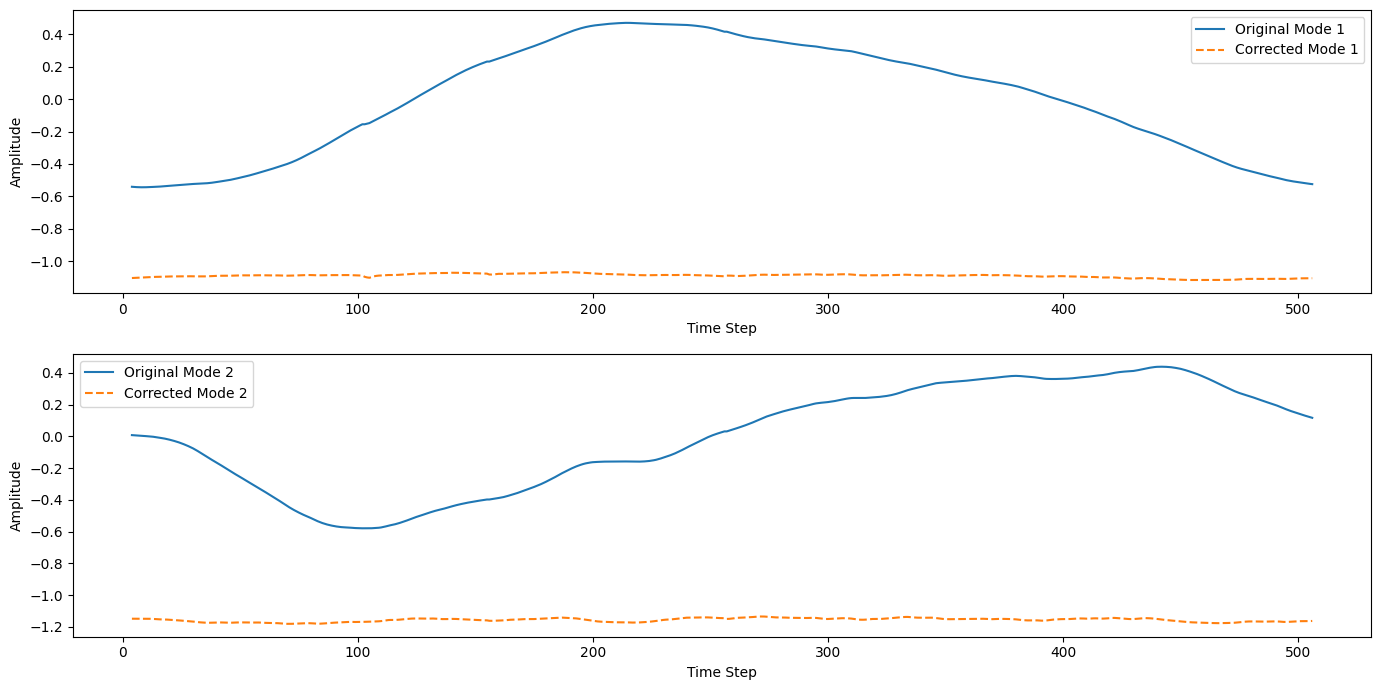

In [68]:
# Correct the modal coefficients
corrected_modes = temporal_coefficients[look_back + 1:] - predicted_correction

# Inverse transform the corrected modes to original scale
corrected_modes = scaler.inverse_transform(corrected_modes)

# Time vector for x-axis
time_steps = np.arange(look_back + 1, len(temporal_coefficients))

# Plot original vs. corrected modal coefficients
plt.figure(figsize=(14, 7))
for i in range(num_modes):
    plt.subplot(num_modes, 1, i + 1)
    plt.plot(time_steps, temporal_coefficients[look_back + 1:, i], label='Original Mode {}'.format(i + 1))
    plt.plot(time_steps, corrected_modes[:, i], label='Corrected Mode {}'.format(i + 1), linestyle='--')
    plt.ylabel('Amplitude')
    plt.xlabel('Time Step')
    plt.legend()

plt.tight_layout()
plt.show()

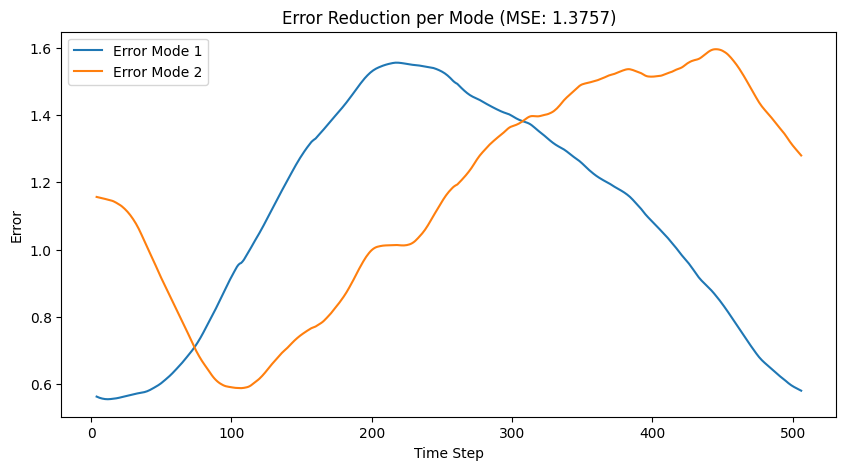

In [70]:
# Calculate errors
errors = temporal_coefficients[look_back + 1:] - corrected_modes
mse = np.mean(errors**2, axis=0)

# Plot error reduction per mode
plt.figure(figsize=(10, 5))
for i in range(num_modes):
    plt.plot(time_steps, errors[:, i], label='Error Mode {}'.format(i + 1))

plt.ylabel('Error')
plt.xlabel('Time Step')
plt.title('Error Reduction per Mode (MSE: {:.4f})'.format(np.mean(mse)))
plt.legend()
plt.show()